In [1]:
# Import packages 

import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torchvision.models import ResNet50_Weights, resnet50
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.io.image import read_image
from matplotlib import colormaps
import numpy as np
import PIL
from PIL import Image
import pandas as pd
from scipy import ndimage
import os
import gc
from sklearn.decomposition import PCA

Device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'PyTorch version= {torch.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

PyTorch version= 2.3.1+cu118
CUDA available= True


#### Load KGM Timeframe Model

Model from: https://github.com/noagarcia/context-art-classification/blob/master/model_kgm.py

In [2]:
class KGM(nn.Module):
    # Inputs an image and ouputs the prediction for the class and the projected embedding into the graph space

    def __init__(self, num_class):
        super(KGM, self).__init__()

        # Load pre-trained visual model
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])

        # Classifier
        self.classifier = nn.Sequential(nn.Linear(2048, num_class))

        # Graph space encoder
        self.nodeEmb = nn.Sequential(nn.Linear(2048, 128))


    def forward(self, img):

        visual_emb = self.resnet(img)
        visual_emb = visual_emb.view(visual_emb.size(0), -1)
        pred_class = self.classifier(visual_emb)
        graph_proj = self.nodeEmb(visual_emb)

        return pred_class

model = KGM(18)
model.cuda()
checkpoint = torch.load(r".\\Data\\Model\\best-kgm-time-model.pth\\best-kgm-time-model.pth", encoding='latin1', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

KGM(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, 

In [3]:
# Use for sanity check of Grad-CAM later on
type_model = KGM(11)
type_model.cuda()
checkpoint = torch.load(r".\\Data\\Model\\best-kgm-type-model.pth\\best-kgm-type-model.pth", encoding='latin1', weights_only=False)
type_model.load_state_dict(checkpoint['state_dict'])
type_model.eval()

KGM(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, 

#### Add hooks to model to get activations and gradients

Reference: https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569

In [4]:
# Define hook functions
def backward_hook(module, grad_input, grad_output):
    module.gradients = grad_output[0]

def forward_hook(module, input, output):
    module.activations = output

def compute_gradcam(model, img_tensor):
    backward_hook_handle = model.resnet[7].register_full_backward_hook(backward_hook)
    forward_hook_handle = model.resnet[7].register_forward_hook(forward_hook)
    
    try:   
        output = model(img_tensor.unsqueeze(0))
        output.sum().backward()

        # Retrieve gradients and activations
        gradients = model.resnet[7].gradients
        activations = model.resnet[7].activations

        # Compute pooled gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Apply gradients to activations
        for i in range(activations.size(1)):
            activations[:, i, :, :] *= pooled_gradients[i]

        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        # Apply ReLU to the heatmap
        heatmap = F.relu(heatmap)

        # Normalize the heatmap
        heatmap /= torch.max(heatmap)

    finally:
        # Ensure hooks are removed
        backward_hook_handle.remove()
        forward_hook_handle.remove()

    torch.cuda.empty_cache()

    return heatmap.detach().cpu().numpy()


def get_activations(model, img_tensor):
    forward_hook_handle = model.resnet[7].register_forward_hook(forward_hook)
    try:
        with torch.no_grad():
            model(img_tensor.unsqueeze(0))
        activations = model.resnet[7].activations
        activations_np = activations.detach().cpu().numpy()
    
    finally:
        forward_hook_handle.remove()
    return activations_np
    

def create_image_tensor(img_path): 
    image_path = r'.\\Data\\Images\\'
    img = read_image(image_path + img_path)
    img_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(Device)
    return img_tensor

In [5]:
def plot_gradcam(heatmap, img_tensor): 
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    img = np.asarray(Image.open(r'.\\Data\\Images\\00076-selfport.jpg'))
    ax1.imshow(img)
    ax1.axis('off')
    ax3.axis('off')
    ax2.matshow(heatmap)
    ax2.axis('off')
    ax3.imshow(to_pil_image(img_tensor, mode='RGB'))
    overlay = to_pil_image(heatmap, mode='F').resize((224,224), resample=PIL.Image.BICUBIC)
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    ax3.imshow(overlay, alpha=0.4, interpolation='nearest')

    plt.show()

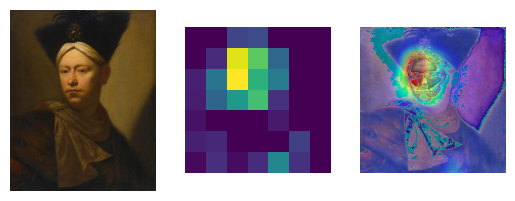

In [6]:
# Sanity
img_tensor = create_image_tensor("00076-selfport.jpg")
heatmap = compute_gradcam(type_model, img_tensor)
plot_gradcam(heatmap, img_tensor)

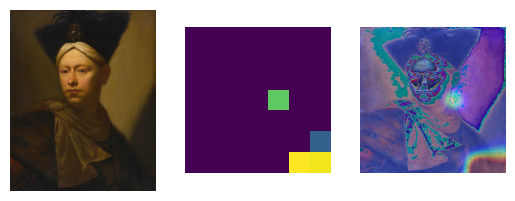

In [7]:
# Sanity
img_tensor = create_image_tensor("00076-selfport.jpg")
heatmap = compute_gradcam(model, img_tensor)
plot_gradcam(heatmap, img_tensor)

#### Collect deep feature activations for every painting

In [8]:
%%time
images_path = r'.//Data//Images//'
im_list = os.listdir(images_path)
activations_list = []
image_names = []
for idx in range(len(im_list)):
    im = im_list[idx]
    try:
        im_tensor = create_image_tensor(im)
        image_names.append(im)
        activation = get_activations(model, im_tensor)
        activations_list.append(activation)
    except: 
        continue

activations_list = np.concatenate(activations_list, axis=0)

CPU times: total: 39min 30s
Wall time: 10min 34s


#### Create dataset with top 20 dominant deep features

In [9]:
num_images, num_channels, height, width = activations_list.shape
pooled_features = activations_list.mean(axis=(2,3))  # shape: (num_images, num_channels)
print(pooled_features.shape)

(21355, 2048)


In [10]:
dominant_features = pooled_features.argmax(axis=1)

In [11]:
from collections import Counter

dominant_keys = Counter(dominant_features).most_common(20)
features = [i[0] for i in dominant_keys]

In [12]:
features_df = pd.DataFrame(data=pooled_features)
features_df = features_df.iloc[:, features]
features_df['image'] = image_names
features_df.index = features_df.image
features_df = features_df.iloc[:, :-1]
features_df.head()

,1064,617,564,624,2018,945,388,1501,1106,1189,1643,279,666,1302,667,1185,1462,1886,758,942
image,,,,,,,,,,,,,,,,,,,,
00000-allegory.jpg,1.611460,1.282985,1.324714,0.542222,0.706765,1.268130,0.315412,2.503468,1.379407,0.322881,1.708178,1.392531,0.885033,0.485514,0.222863,0.982856,0.366072,1.215412,1.085157,0.140098
00002-j_couple.jpg,0.809120,1.342070,0.760372,1.489934,0.792368,0.893135,1.435088,1.558626,1.312958,0.312761,0.265846,1.086718,0.627048,1.121855,1.001378,0.578688,1.300461,1.238085,1.201420,0.584948
00003-rudolf2.jpg,1.093800,0.461348,1.046283,0.376142,1.329826,1.083261,1.021220,1.256559,1.054622,0.271907,0.828642,1.062788,1.485189,0.724123,1.255634,0.420330,0.578633,0.797441,0.984092,0.085477
00004-selfport.jpg,1.438789,1.205789,1.062270,0.076016,2.695276,0.903129,1.672469,1.151040,3.308040,0.384790,0.310221,1.272130,0.703636,0.423299,1.319442,0.879134,2.129411,2.116234,1.032283,0.246957
00005-deerlake.jpg,3.761074,1.317931,2.822557,0.156005,1.067042,0.090015,2.445269,3.515824,0.872346,1.162925,2.117369,1.061466,0.432336,0.049647,0.198289,0.014202,0.805407,0.809965,0.415413,0.457639


In [13]:
features_df.to_csv(r'.\\Data\\deep_features.csv')